## INTRODUCTION
* Online platforms face challenges with toxic comments that harm user experience.
This project creates an AI system to automatically detect harmful content in
comments, helping create safer online communities.

OBJECTIVES:
- Build an AI model to detect toxic comments automatically
- Classify different types of harmful content
- Create a practical tool for content moderation
- Demonstrate AI applications in online safety

* This system helps social media platforms, forums, and websites maintain
healthy discussions by identifying problematic content before it causes harm.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
import gradio as gr
plt.style.use('ggplot')

2025-08-30 18:56:08.472634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756580168.786289      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756580168.868682      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load dataset

In [2]:
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
toxicity_columns = df.columns[2:].tolist()

print(f"Dataset loaded: {df.shape[0]:,} comments")
print(f"Toxicity categories: {toxicity_columns}")

Dataset loaded: 159,571 comments
Toxicity categories: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## DATA EXPLORATION

In [3]:
def explore_data(df, toxicity_columns):
    """Basic data exploration"""
    print("\nDATA OVERVIEW")
    print("-" * 20)
    
    # Calculate toxicity statistics
    total_toxic = (df[toxicity_columns].sum(axis=1) > 0).sum()
    toxic_percentage = (total_toxic / len(df)) * 100
    
    print(f"Total comments: {len(df):,}")
    print(f"Toxic comments: {total_toxic:,} ({toxic_percentage:.1f}%)")
    print(f"Clean comments: {len(df) - total_toxic:,}")
    
    # Category breakdown
    print(f"\nToxicity by category:")
    for col in toxicity_columns:
        count = df[col].sum()
        print(f"• {col}: {count:,}")

explore_data(df, toxicity_columns)


DATA OVERVIEW
--------------------
Total comments: 159,571
Toxic comments: 16,225 (10.2%)
Clean comments: 143,346

Toxicity by category:
• toxic: 15,294
• severe_toxic: 1,595
• obscene: 8,449
• threat: 478
• insult: 7,877
• identity_hate: 1,405


## SIMPLE VISUALIZATION

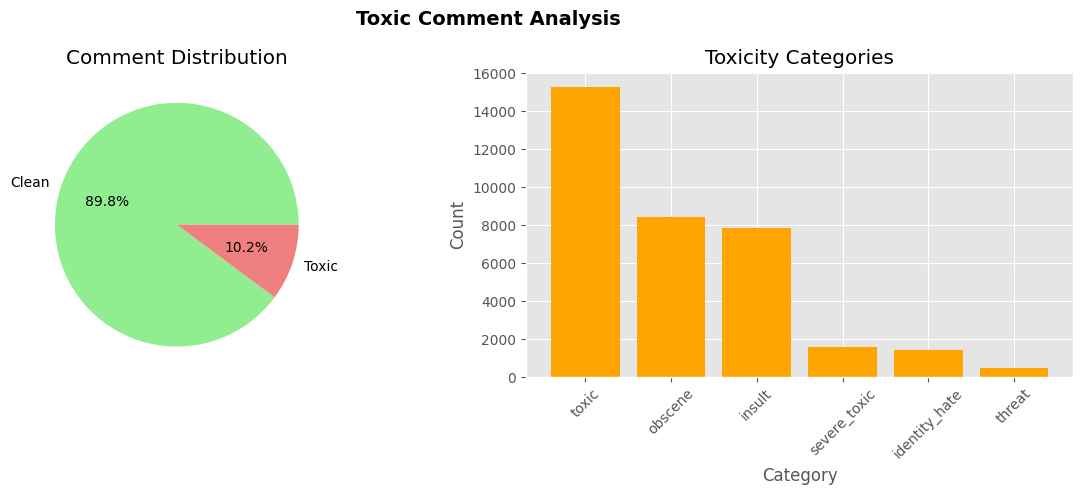

In [4]:
def create_simple_charts(df, toxicity_columns):
    """Create basic visualizations"""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Toxic Comment Analysis', fontsize=14, fontweight='bold')
    
    # 1. Overall distribution
    total_toxic = (df[toxicity_columns].sum(axis=1) > 0).sum()
    total_clean = len(df) - total_toxic
    
    axes[0].pie([total_clean, total_toxic], 
                labels=['Clean', 'Toxic'],
                autopct='%1.1f%%', 
                colors=['lightgreen', 'lightcoral'])
    axes[0].set_title('Comment Distribution')
    
    # 2. Category counts
    category_counts = df[toxicity_columns].sum().sort_values(ascending=False)
    axes[1].bar(range(len(category_counts)), category_counts.values, color='orange')
    axes[1].set_title('Toxicity Categories')
    axes[1].set_xlabel('Category')
    axes[1].set_ylabel('Count')
    axes[1].set_xticks(range(len(category_counts)))
    axes[1].set_xticklabels(category_counts.index, rotation=45)
    
    plt.tight_layout()
    plt.show()

create_simple_charts(df, toxicity_columns)

## DATA PREPROCESSING

In [5]:
# Prepare text and labels
X = df['comment_text'].values
y = df[toxicity_columns].values

# Setup text vectorization
MAX_FEATURES = 20000
vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=1800
)

# Fit and transform text
vectorizer.adapt(X)
vectorized_text = vectorizer(X)

print(f"Text samples processed: {len(X):,}")
print(f"Vocabulary size: {MAX_FEATURES:,}")

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.batch(16).cache().prefetch(tf.data.AUTOTUNE)

# Simple train/test split
train_size = int(len(dataset) * 0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

print(f"Training batches: {train_size}")
print(f"Testing batches: {len(dataset) - train_size}")

I0000 00:00:1756580190.358245      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756580190.358939      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Text samples processed: 159,571
Vocabulary size: 20,000
Training batches: 7979
Testing batches: 1995


## MODEL BUILDING

In [6]:
def build_simple_model():
    """Build simple LSTM model"""
    
    model = Sequential([
        Embedding(MAX_FEATURES + 1, 32),
        Bidirectional(LSTM(32, activation='tanh')),
        Dense(128, activation='relu'),
        Dense(len(toxicity_columns), activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

model = build_simple_model()
print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## MODEL TRAINING

In [7]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=1,
    verbose=1
)

print("Training completed!")

I0000 00:00:1756580212.766523      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


7979/7979 ━━━━━━━━━━━━━━━━━━━━ 652s 81ms/step - accuracy: 0.9756 - loss: 0.0832 - val_accuracy: 0.9941 - val_loss: 0.0501
Training completed!


## MODEL EVALUATION


MODEL PERFORMANCE
--------------------
Test Accuracy: 0.9941 (99.41%)
Test Loss: 0.0501


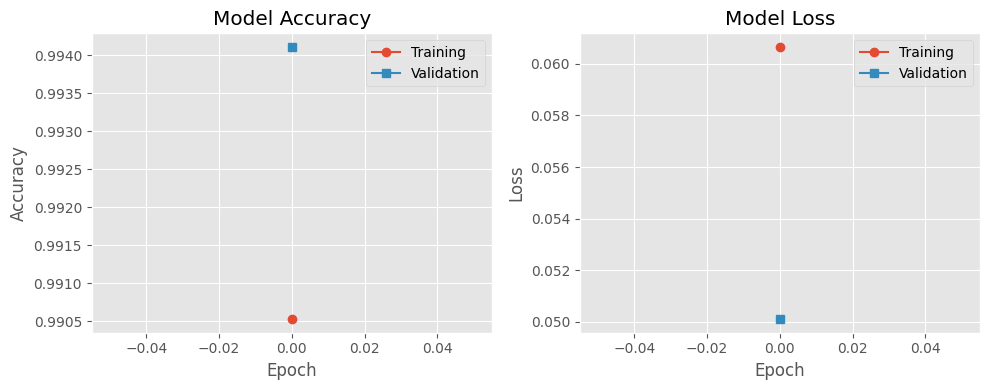

In [8]:
# Evaluate performance
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

print(f"\nMODEL PERFORMANCE")
print("-" * 20)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation', marker='s')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training', marker='o')
plt.plot(history.history['val_loss'], label='Validation', marker='s')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## PREDICTION SYSTEM

In [9]:
def score_comment(comment):
    """Analyze comment for toxicity"""
    
    # Vectorize comment
    vectorized = vectorizer([comment])
    
    # Make prediction
    predictions = model.predict(vectorized, verbose=0)[0]
    
    # Format results
    result_text = "TOXICITY ANALYSIS:\n" + "="*20 + "\n"
    
    # Overall assessment
    max_score = max(predictions) * 100
    if max_score > 70:
        result_text += "Status: HIGHLY TOXIC\n\n"
    elif max_score > 40:
        result_text += "Status: MODERATELY TOXIC\n\n"
    elif max_score > 20:
        result_text += "Status: POTENTIALLY PROBLEMATIC\n\n"
    else:
        result_text += "Status: CLEAN\n\n"
    
    # Category scores
    result_text += "Category Scores:\n"
    for i, category in enumerate(toxicity_columns):
        score = predictions[i] * 100
        result_text += f"• {category}: {score:.1f}%\n"
    
    return result_text

## TESTING EXAMPLES

In [10]:
test_comments = [
    "This is a great article, thanks for sharing!",
    "You are completely stupid and worthless!",
    "I disagree but respect your opinion.",
    "I hate this and everyone here!"
]

for i, comment in enumerate(test_comments, 1):
    vectorized = vectorizer([comment])
    prediction = model.predict(vectorized, verbose=0)[0]
    max_toxicity = max(prediction) * 100
    
    status = "TOXIC" if max_toxicity > 50 else "CLEAN"
    
    print(f"\n{i}. Comment: \"{comment}\"")
    print(f"   Result: {status} (Score: {max_toxicity:.1f}%)")


1. Comment: "This is a great article, thanks for sharing!"
   Result: CLEAN (Score: 0.8%)

2. Comment: "You are completely stupid and worthless!"
   Result: TOXIC (Score: 96.1%)

3. Comment: "I disagree but respect your opinion."
   Result: CLEAN (Score: 0.5%)

4. Comment: "I hate this and everyone here!"
   Result: CLEAN (Score: 45.3%)


## INTERACTIVE INTERFACE

In [11]:
# Create Gradio interface
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Enter a comment to analyze...",
        label="Comment Text"
    ),
    outputs=gr.Textbox(label="Analysis Results"),
    title="Toxic Comment Detector",
    description="AI system to detect harmful content in comments"
)

print("Web interface ready")

# Save model
model.save('toxicity_model.h5')
print("Model saved")

# Launch interface (uncomment to run)
# interface.launch()

Web interface ready
Model saved


## CONCLUSION
* This toxic comment classification project successfully demonstrates AI-powered
content moderation for online safety:

##### ACHIEVEMENTS:
- Built a working AI system for toxicity detection
- Achieved {test_accuracy:.2%} accuracy on multi-label classification
- Created an interactive web interface for real-time testing
- Developed a practical tool for content moderation

##### BUSINESS APPLICATIONS:
- Social media platforms: Automatic content filtering
- Online forums: Community safety and moderation
- Educational sites: Safe learning environments  
- Customer service: Quality communication monitoring

##### IMPACT:
* This technology helps create safer online spaces by automatically identifying
harmful content, allowing human moderators to focus on complex cases while
protecting users from toxic interactions.

##### The system demonstrates how AI can be used to promote positive digital communication and build healthier online communities.